# Proyek Klasifikasi Gambar: []
- **Nama:** [Dea Yuliani Sabrina]
- **Email:** [deayulianis788@gmail.com]
- **ID Dicoding:** [MC009D5X0397]

" ::::: "

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwinurcahyop","key":"ebbe1dffa9eb5d105fff289c1adaeaf1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Ganti 'username' dan 'dataset-name' sesuai dengan dataset yang kamu pakai
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d intel-image-classification

Streaming output truncated to the last 5000 lines.
  inflating: intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/

In [5]:
import os
import shutil

# Path ke folder sumber
folder1 = '/content/intel-image-classification/seg_test/seg_test'
folder2 = '/content/intel-image-classification/seg_train/seg_train'

# Path ke folder tujuan gabungan
combined_folder = '/content/all_data'

# Daftar kategori/subfolder
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Pastikan struktur folder gabungan sudah dibuat
for category in categories:
    dst_subfolder = os.path.join(combined_folder, category)
    os.makedirs(dst_subfolder, exist_ok=True)

    # Salin dari folder1
    src1 = os.path.join(folder1, category)
    if os.path.exists(src1):
        for filename in os.listdir(src1):
            src_file = os.path.join(src1, filename)
            dst_file = os.path.join(dst_subfolder, filename)

            # Hindari overwrite
            if os.path.exists(dst_file):
                base, ext = os.path.splitext(filename)
                counter = 1
                while os.path.exists(dst_file):
                    new_filename = f"{base}_{counter}{ext}"
                    dst_file = os.path.join(dst_subfolder, new_filename)
                    counter += 1
            shutil.copy2(src_file, dst_file)

    # Salin dari folder2
    src2 = os.path.join(folder2, category)
    if os.path.exists(src2):
        for filename in os.listdir(src2):
            src_file = os.path.join(src2, filename)
            dst_file = os.path.join(dst_subfolder, filename)

            if os.path.exists(dst_file):
                base, ext = os.path.splitext(filename)
                counter = 1
                while os.path.exists(dst_file):
                    new_filename = f"{base}_{counter}{ext}"
                    dst_file = os.path.join(dst_subfolder, new_filename)
                    counter += 1
            shutil.copy2(src_file, dst_file)

print("Semua data berhasil digabung ke folder baru.")


Semua data berhasil digabung ke folder baru.


### Data Preprocessing

#### Split Dataset

In [6]:
import os
import shutil
import random

# Set seed agar hasil acak konsisten
random.seed(42)

# Path ke folder input gabungan (sudah berisi subfolder: buildings, forest, dst)
input_folder = '/content/all_data'

# Path ke folder output hasil split
output_base = '/content/dataset_split'

# Subfolder kategori (pastikan sesuai isi folder)
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Persentase split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Fungsi untuk membagi dan menyimpan gambar
def split_and_save(category_name):
    src_path = os.path.join(input_folder, category_name)
    images = os.listdir(src_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)
    test_count = total - train_count - val_count  # Sisa ke test

    split_map = {
        'train': images[:train_count],
        'val': images[train_count:train_count + val_count],
        'test': images[train_count + val_count:]
    }

    for split, image_list in split_map.items():
        split_folder = os.path.join(output_base, split, category_name)
        os.makedirs(split_folder, exist_ok=True)

        for img in image_list:
            src = os.path.join(src_path, img)
            dst = os.path.join(split_folder, img)

            # Hindari overwrite nama file
            if os.path.exists(dst):
                base, ext = os.path.splitext(img)
                counter = 1
                while os.path.exists(dst):
                    new_name = f"{base}_{counter}{ext}"
                    dst = os.path.join(split_folder, new_name)
                    counter += 1

            shutil.copy2(src, dst)

# Proses semua kategori
for category in categories:
    split_and_save(category)

print("Dataset berhasil dibagi dan disimpan ke folder baru: train / val / test.")


Dataset berhasil dibagi dan disimpan ke folder baru: train / val / test.


## Modelling

In [24]:
# Ukuran gambar
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Path ke folder dataset
train_dir = '/content/dataset_split/train'
val_dir = '/content/dataset_split/val'
test_dir = '/content/dataset_split/test'

# Preprocessing dan augmentasi
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11920 images belonging to 6 classes.
Found 2552 images belonging to 6 classes.
Found 2562 images belonging to 6 classes.


In [25]:
# CNN Model: menggunakan Conv2D, Pooling, dan Fully Connected Layer
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ringkasan model
model.summary()

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601,478 (13.74 MB)

 Trainable params: 3,601,478 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 75s 191ms/step - accuracy: 0.4491 - loss: 1.3269 - val_accuracy: 0.6246 - val_loss: 0.9138
Epoch 2/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - accuracy: 0.6930 - loss: 0.8271 - val_accuracy: 0.7426 - val_loss: 0.6843
Epoch 3/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 68s 183ms/step - accuracy: 0.7403 - loss: 0.7132 - val_accuracy: 0.7927 - val_loss: 0.5920
Epoch 4/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 67s 180ms/step - accuracy: 0.7905 - loss: 0.5860 - val_accuracy: 0.8013 - val_loss: 0.5570
Epoch 5/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 69s 185ms/step - accuracy: 0.8061 - loss: 0.5278 - val_accuracy: 0.8272 - val_loss: 0.5101
Epoch 6/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.8318 - loss: 0.4746 - val_accuracy: 0.8131 - val_loss: 0.5411
Epoch 7/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.8465 - loss: 0.4292 - val_accuracy: 0.7927 - val_loss: 0.5575
Epoch 8/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 67s 180ms/step - accuracy: 0.8585 - loss: 0

## Evaluasi dan Visualisasi

In [28]:
# Evaluasi di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\n🎯 Akurasi Test: {test_acc:.2%}')

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8900 - loss: 0.4134

🎯 Akurasi Test: 85.01%


In [27]:
# Evaluasi di train set
train_loss, train_acc = model.evaluate(train_generator)
print(f'\n🎯 Akurasi train: {train_acc:.2%}')

373/373 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9465 - loss: 0.1539

🎯 Akurasi train: 94.87%


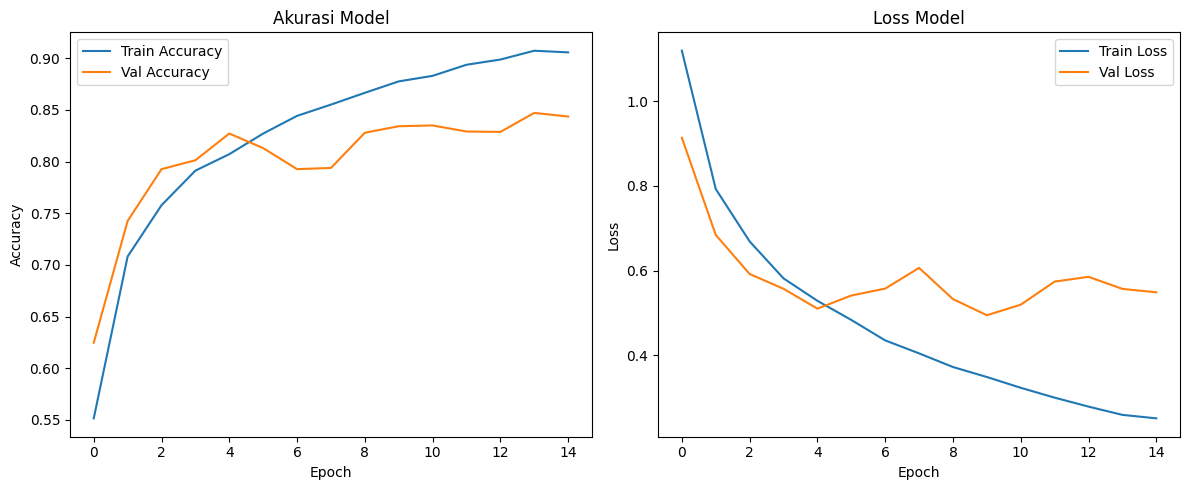

In [30]:
import matplotlib.pyplot as plt

# Ambil nilai dari objek history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Classification Report:

              precision    recall  f1-score   support

   buildings       0.76      0.91      0.83       395
      forest       0.93      0.97      0.95       413
     glacier       0.80      0.80      0.80       445
    mountain       0.84      0.79      0.81       457
         sea       0.90      0.85      0.87       419
      street       0.90      0.79      0.84       433

    accuracy                           0.85      2562
   macro avg       0.85      0.85      0.85      2562
weighted avg       0.85      0.85      0.85      2562



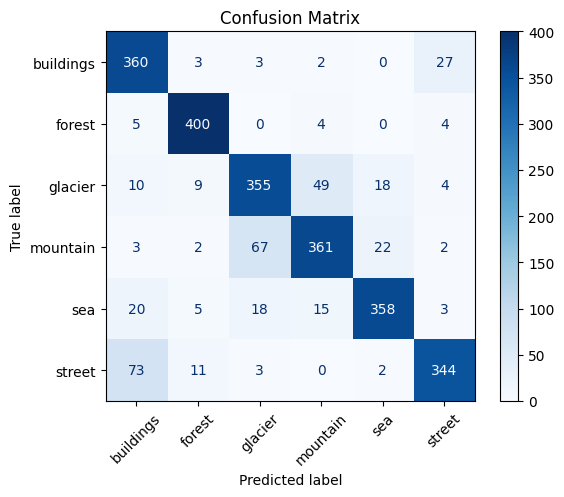

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Confusion Matrix dan Classification Report ---

# Pastikan kamu sudah punya test_data
# Contoh: test_data = datagen.flow_from_directory(..., shuffle=False)

# Prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

## Konversi Model

In [35]:
# 1. Export ke SavedModel (buat TF-Lite/TFJS)
model.export('saved_model/intel-image-classification')

# 2. Convert ke TF-Lite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/intel-image-classification')
tflite_model = converter.convert()

with open('intel-image-classification.tflite', 'wb') as f:
    f.write(tflite_model)

# 3. Convert ke TensorFlowJS
!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.convert_tf_saved_model('saved_model/intel-image-classification', 'tfjs_model')

print("\nSemua format model berhasil disimpan!")

Saved artifact at 'saved_model/intel-image-classification'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_65')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135995128149392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128148432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128143440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128148816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128145360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128147664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128149200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135995128148240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135993467439248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135993467446160: TensorSpec(shape=(), dtype=tf.resource, na


Semua format model berhasil disimpan!


In [37]:
import os
import zipfile
import shutil
import pkg_resources

# 1. Siapkan folder struktur "submission"
submission_dir = 'submission'
os.makedirs(os.path.join(submission_dir, 'tfjs_model'), exist_ok=True)
os.makedirs(os.path.join(submission_dir, 'tflite'), exist_ok=True)
os.makedirs(os.path.join(submission_dir, 'saved_model'), exist_ok=True)

# 2. Pindahkan hasil model ke folder yang sesuai
shutil.copytree('tfjs_model', os.path.join(submission_dir, 'tfjs_model'), dirs_exist_ok=True)
shutil.copy('intel-image-classification.tflite', os.path.join(submission_dir, 'tflite', 'model.tflite'))
shutil.copytree('/content/saved_model/intel-image-classification', os.path.join(submission_dir, 'saved_model'), dirs_exist_ok=True)

# 3. Tambahkan README.md dan tulis requirements.txt hanya untuk paket yang digunakan
with open(os.path.join(submission_dir, 'README.md'), 'w') as f:
    f.write("# Submission\n\nPenjelasan singkat tentang project ini.")

used_packages = ["tensorflow", "tensorflowjs", "matplotlib", "numpy"]
requirements = []
for package in used_packages:
    try:
        version = pkg_resources.get_distribution(package).version
        requirements.append(f"{package}=={version}")
    except pkg_resources.DistributionNotFound:
        print(f"Package {package} tidak ditemukan di environment.")

with open(os.path.join(submission_dir, 'requirements.txt'), 'w') as f:
    f.write("\n".join(requirements))

# 4. Buat file label.txt jika train_generator tersedia
try:
    with open(os.path.join(submission_dir, 'tflite', 'label.txt'), 'w') as f:
        for label in train_generator.class_indices.keys():
            f.write(label + '\n')
except NameError:
    print("train_generator belum didefinisikan. Lewati pembuatan label.txt.")

# 5. Zip folder "submission"
zip_filename = "submission.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(submission_dir):
        for file in files:
            filepath = os.path.join(root, file)
            zipf.write(filepath, os.path.relpath(filepath, submission_dir))

print(f"Folder 'submission' berhasil di-zip ke {zip_filename}")


Folder 'submission' berhasil di-zip ke submission.zip


## Inference (Optional)